In [1]:
import numpy as np
import matplotlib.pyplot as plt
import burst_detector as bd
import seaborn as sns
from scipy.stats import wasserstein_distance
import pandas as pd
import math

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
n_chan = 385
times = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_times.npy').flatten()
clusters = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_clusters.npy').flatten()
mean_wf = np.load("../data/neuropixels_dohoung/KS2.5/phy_in/mean_waveforms.npy")

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv("../data/neuropixels_dohoung/KS2.5/phy_in/cluster_group.tsv", sep="\t")

In [3]:
# load raw data
rawData = np.memmap("../data/neuropixels_dohoung/KS2.5/catgt_ANM480363_20210527_pfc320_hpc180_g0/ANM480363_20210527_pfc320_hpc180_g0_imec1/ANM480363_20210527_pfc320_hpc180_g0_tcat.imec1.ap.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [4]:
params = {}

# mean calculation
params['calc_means'] = True
params['fs'] = 30000
params['n_chan'] = 128
params['pre_samples'] = 20
params['post_samples'] = 62
params['max_spikes'] = 2000

# mean sim
params['jitter'] = False
params['jitter_amt'] = -1
params['sim_thresh'] = .4
params['sp_num_thresh'] 100

# xcorr metric
params['n_iter'] = 50
params['shuffle_bin_width'] = 0.1
params['window_size'] = 0.025
params['xcorr_bin_width'] = .001
params['overlap_tol'] = 10/params['fs']
params['max_window'] = 0.25
params['min_xcorr_rate'] = .8/.001

# ref p
params['xcorr_ref_p'] = 0.001


SyntaxError: invalid syntax (2472889640.py, line 15)

### Mean similarity

In [ ]:
mean_sim, offset, wf_means_norm = bd.wf_means_similarity(mean_wf)
plt.imshow(mean_sim)
plt.colorbar(); plt.title("Mean waveform similarity in rat hippocampus");

In [ ]:
sim_thresh = 0.4
sp_num_thresh = 100

### Cross projection similarity

In [ ]:
# # params for merge candidates
# num  = 0
# wass_d = np.ones_like(mean_sim)
# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
        
#         # keep similar cluster pairs where one has sufficient spikes and both are not noise
#         if mean_sim[c1,c2] >= sim_thresh and ((counts[c1] >= sp_num_thresh) or (counts[c2] >= sp_num_thresh)):
#             if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                
#                 # extract spikes
#                 sp_1 = bd.extract_spikes(data, times, clusters, c1)
#                 sp_2 = bd.extract_spikes(data, times, clusters, c2)
                
#                 # compute cross-projections
#                 proj_1on1, proj_2on1, proj_1on2, proj_2on2 = bd.cross_proj(sp_1, sp_2, wf_means_norm[c1], wf_means_norm[c2])
                
#                 # bound outliers
#                 dist_1on2 = proj_1on2/proj_1on1
#                 dist_1on2[dist_1on2 > 1] = 1
#                 dist_1on2[dist_1on2 < 0] = 0
                
#                 dist_2on1 = proj_2on1/proj_2on2
#                 dist_2on1[dist_2on1 > 1] = 1
#                 dist_2on1[dist_2on1 < 0] = 0
                
#                 # compute wasserstein distances
#                 wass_d[c1, c2] = wasserstein_distance(proj_1on1/proj_1on1, dist_1on2)
#                 wass_d[c2, c1] = wasserstein_distance(proj_2on2/proj_2on2, dist_2on1)
                
#                 num += 1
#                 if (num % 10 == 0):
#                     print("finished pair %d" % num)
                    
# np.save("hippo_wass_d.npy", wass_d)

wass_d = np.load("hippo_wass_d.npy")
wass_sim = 1-wass_d

# 59 mins

In [5]:
pass_1 = np.zeros_like(mean_sim, dtype='bool')
for c1 in range(counts.shape[0]): 
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if mean_sim[c1,c2] >= sim_thresh and ((counts[c1] >= sp_num_thresh) or (counts[c2] >= sp_num_thresh)):
            if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                pass_1[c1,c2] = True
                pass_1[c2,c1] = True

NameError: name 'mean_sim' is not defined

In [6]:
plt.imshow(1-wass_d)
plt.colorbar(); plt.title("1 - Wasserstein distance in rat hippocampus");

NameError: name 'wass_d' is not defined

In [15]:
wass_sim = 1-wass_d

merge_dec = np.zeros_like(mean_sim)
wass_thresh = 0.75
num = 0

for c1 in range(counts.shape[0]): 
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if pass_1[c1,c2]:
            if (wass_sim[c1, c2] > wass_thresh) and (wass_sim[c2, c1] > wass_thresh):
                merge_dec[c1, c2] = 1
                merge_dec[c2, c1] = 1                

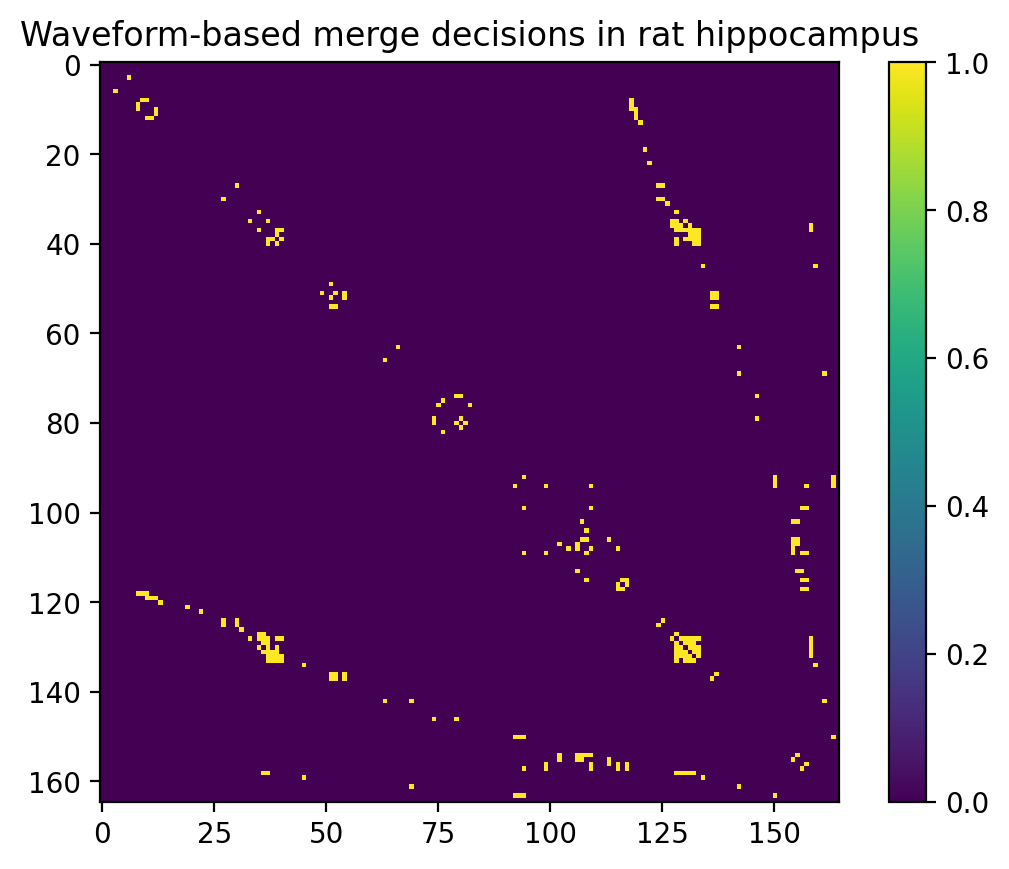

In [16]:
plt.imshow(merge_dec)
plt.colorbar();
plt.title("Waveform-based merge decisions in rat hippocampus");

### Cross-correlation metric

In [17]:
# compute refractory periods
isi_est = bd.get_isi_est(times, clusters, counts, sp_num_thresh, isi_prct=50)

In [18]:
# compute ccgs and shuffled ccgs
# num = 0
# xgrams = np.empty_like(mean_sim, dtype='object')
# x_olaps = np.zeros_like(mean_sim)
# shfl_xgrams = np.empty_like(mean_sim, dtype='object')
# shfl_olaps = np.zeros_like(mean_sim)

# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
#         if pass_1[c1, c2]:
#             # extract spike times
#             cl_times = bd.find_times_multi(times/30000, clusters, [c1, c2])
#             c1_times = cl_times[0]
#             c2_times = cl_times[1]
            
#             xcorr_bin_width = 0.001
                
#             # compute xgrams
#             xgram, x_olap, shfl_xgram, shfl_olap = bd.calc_xgrams(c1_times, c2_times, xcorr_bin_width=xcorr_bin_width, overlap_tol=10/30000)
            
#             xgrams[c1,c2] = xgram
#             x_olaps[c1,c2] = x_olap
#             shfl_xgrams[c1,c2] = shfl_xgram
#             shfl_olaps[c1,c2] = shfl_olap
            
#             num += 1
#             if (num % 10 == 0):
#                 print("finished pair %d" % num)
                
# np.save("hippo_xgrams.npy", xgrams)
# np.save("hippo_x_olaps.npy", x_olaps)
# np.save("hippo_shfl_xgrams.npy", shfl_xgrams)
# np.save("hippo_shfl_olaps.npy", shfl_olaps)

xgrams = np.load("hippo_xgrams.npy", allow_pickle=True)
x_olaps = np.load("hippo_x_olaps.npy")
shfl_xgrams = np.load("hippo_shfl_xgrams.npy", allow_pickle=True)
shfl_olaps = np.load("hippo_shfl_olaps.npy")

In [44]:
# compute cross-correlation
num  = 0
xcorr_sig = np.zeros_like(mean_sim)

for c1 in range(counts.shape[0]):
    for c2 in range(c1+1, counts.shape[0]):
        if pass_1[c1,c2]:
                # adaptive bin size
                xcorr_window = .025
                xcorr_bin_width = 0.001
                
                # compute significance
                xcorr_sig[c1,c2] = bd.xcorr_sig(xgrams[c1,c2], shfl_xgrams[c1,c2], window_size=xcorr_window, xcorr_bin_width=xcorr_bin_width,  min_xcorr_rate=.5/.001)
                
# copy across the diagonal
for c1 in range(counts.shape[0]):
    for c2 in range(c1+1, counts.shape[0]):
        xcorr_sig[c2,c1] = xcorr_sig[c1,c2]

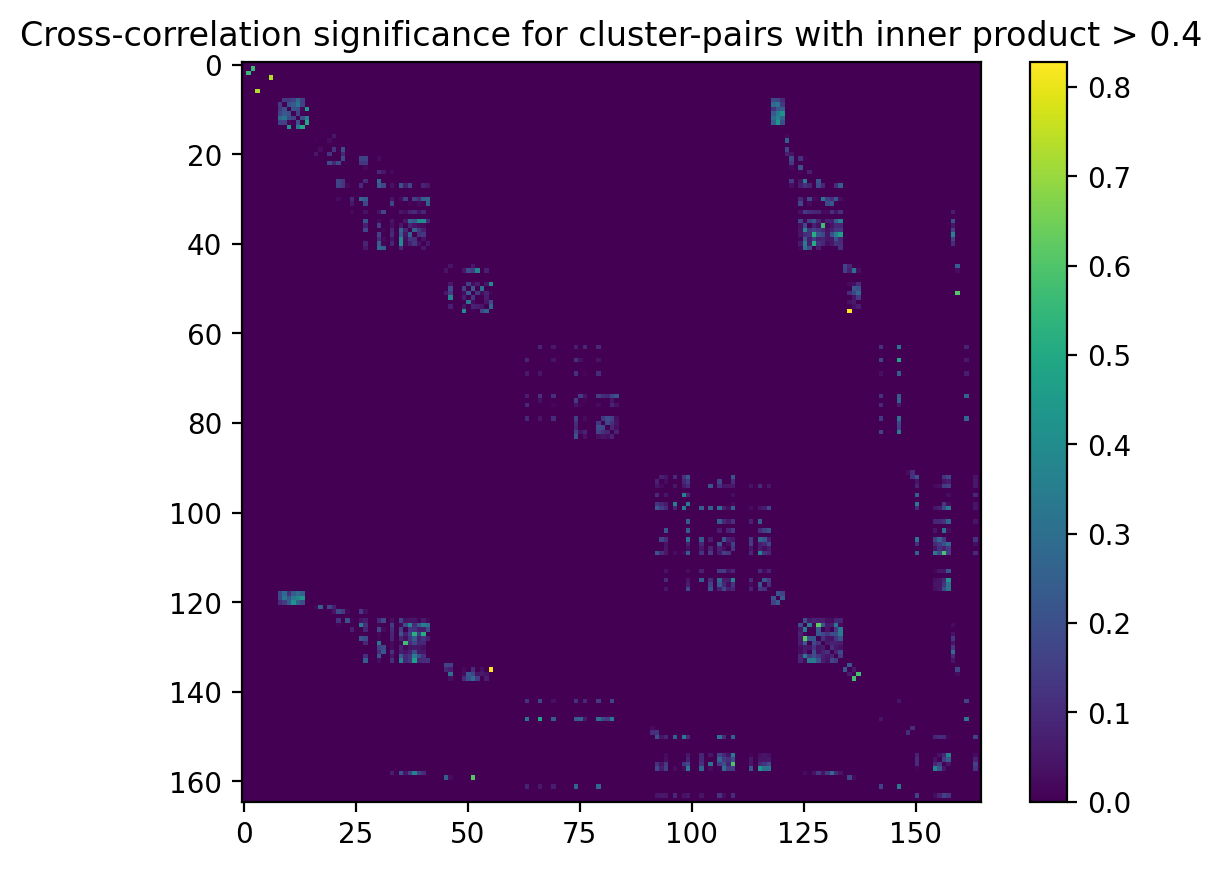

In [45]:
plt.imshow(xcorr_sig); plt.colorbar();
plt.title("Cross-correlation significance for cluster-pairs with inner product > 0.4");

In [197]:
(np.array(np.unravel_index(np.argsort(xcorr_sig.flatten()), xcorr_sig.shape)).T)[-20:]

array([[127,  40],
       [ 40, 127],
       [ 38, 127],
       [127,  38],
       [  1,   2],
       [  2,   1],
       [129,  36],
       [ 36, 129],
       [136, 137],
       [137, 136],
       [156, 109],
       [109, 156],
       [ 51, 159],
       [159,  51],
       [125, 128],
       [128, 125],
       [  3,   6],
       [  6,   3],
       [135,  55],
       [ 55, 135]], dtype=int64)

### Refractory period penalty

In [59]:
ref_pen = np.zeros_like(mean_sim)

for c1 in range(counts.shape[0]):
    for c2 in range(c1+1, counts.shape[0]):
        if (pass_1[c1,c2]) and xcorr_sig[c1,c2] > 0:
            
            # extract spike times
            cl_times = bd.find_times_multi(times/30000, clusters, [c1, c2])
            c1_times = cl_times[0]
            c2_times = cl_times[1]
            
            # adaptive bin size
            xcorr_isi_est = .05
            xcorr_bin_width = .001
            xcorr_ref_p = .001
            
            # find refractory period bin indices
            xgram = xgrams[c1,c2]
            num_bins = round(xcorr_ref_p/xcorr_bin_width)

            ref_start =int(xgram.shape[0]/2) - num_bins
            ref_end = int(xgram.shape[0]/2) - 1 + num_bins
            
            # calculate and scale autocorrelograms
            c1_autocg = bd.auto_correlogram(c1_times, bin_width=xcorr_bin_width)
            c2_autocg = bd.auto_correlogram(c2_times, bin_width=xcorr_bin_width)
            
            # scale and check for empty autocgs
            if (c1_autocg.max() == 0) and (c2_autocg.max() == 0):
                ref_pen[c1,c2] = 0
                continue
                
            elif (c1_autocg.max() == 0):
                c1_autocg = np.zeros_like(c1_autocg)
                c2_autocg /= c2_autocg.max()
                
            elif (c2_autocg.max() == 0):
                c2_autocg = np.zeros_like(c2_autocg)
                c1_autocg /= c1_autocg.max()
            
            else:
                c1_autocg /= c1_autocg.max()
                c2_autocg /= c2_autocg.max()   
            
            # calculate and scale bounds
            ref_viol_low = min(c1_autocg[ref_start:ref_end+1].sum(), c2_autocg[ref_start:ref_end+1].sum())
            ref_viol_high = (shfl_xgrams[c1,c2][ref_start:ref_end+1].sum())
            
            ref_viol_high /= shfl_xgrams[c1,c2].max()
            
            # calculate ref period penalty
            ref_viol_ccg = (xgrams[c1,c2][ref_start:ref_end+1].sum())
            ref_viol_ccg /= shfl_xgrams[c1,c2].max()
            
            ref_pen[c1,c2] = bd.calc_ref_pen(ref_viol_ccg, ref_viol_low, ref_viol_high)

# copy across the diagonal
for c1 in range(counts.shape[0]):
    for c2 in range(c1+1, counts.shape[0]):
        ref_pen[c2,c1] = ref_pen[c1,c2]

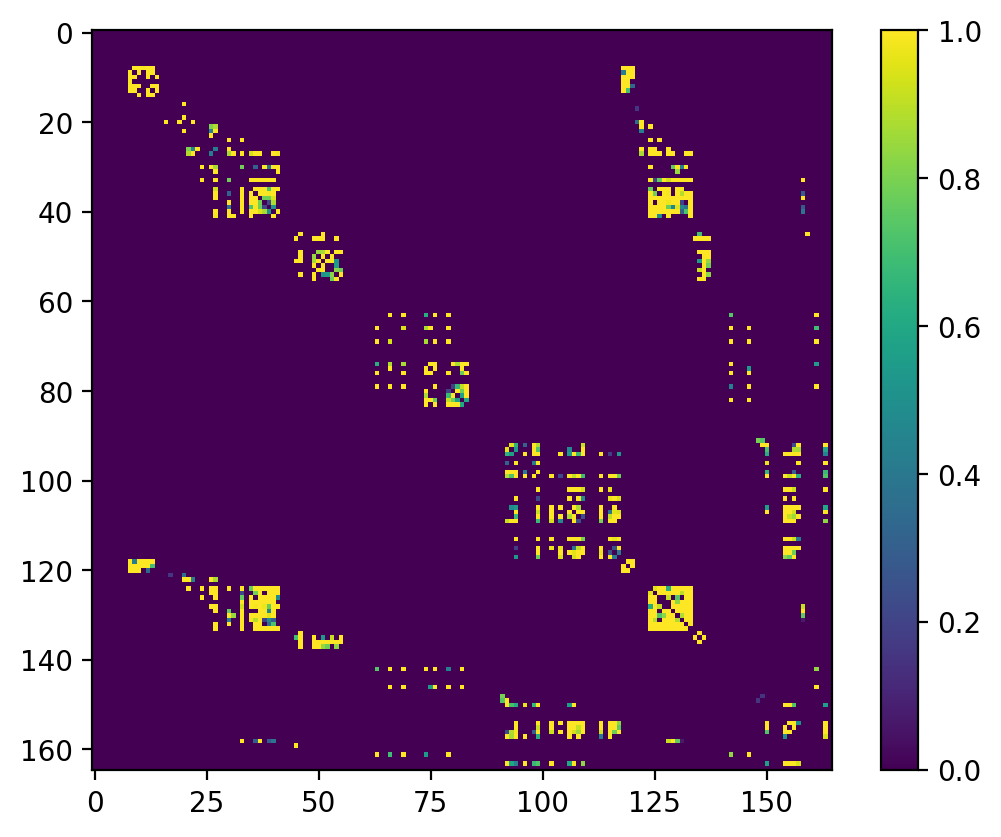

In [60]:
plt.imshow(ref_pen); plt.colorbar()

In [62]:
ref_pen[9,118]

0.42356149440959984

### Final metric

In [63]:
final_metric = np.zeros_like(mean_sim)

for c1 in range(counts.shape[0]):
    for c2 in range(c1, counts.shape[0]):
        val = np.sqrt(wass_sim[c1,c2]*wass_sim[c2,c1]) + .5*xcorr_sig[c1,c2] - .5*ref_pen[c1,c2]
        final_metric[c1,c2] = max(val,0)
        final_metric[c2,c1] = max(val,0)

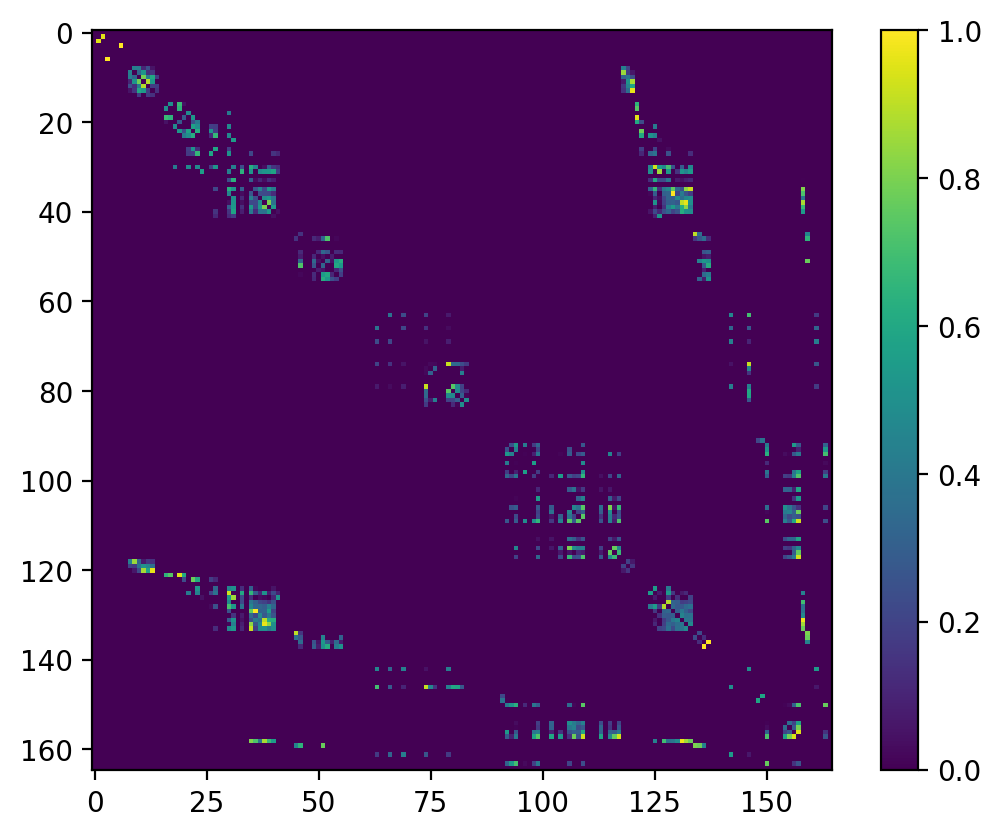

In [64]:
plt.imshow(final_metric, vmin=0, vmax=1); plt.colorbar();

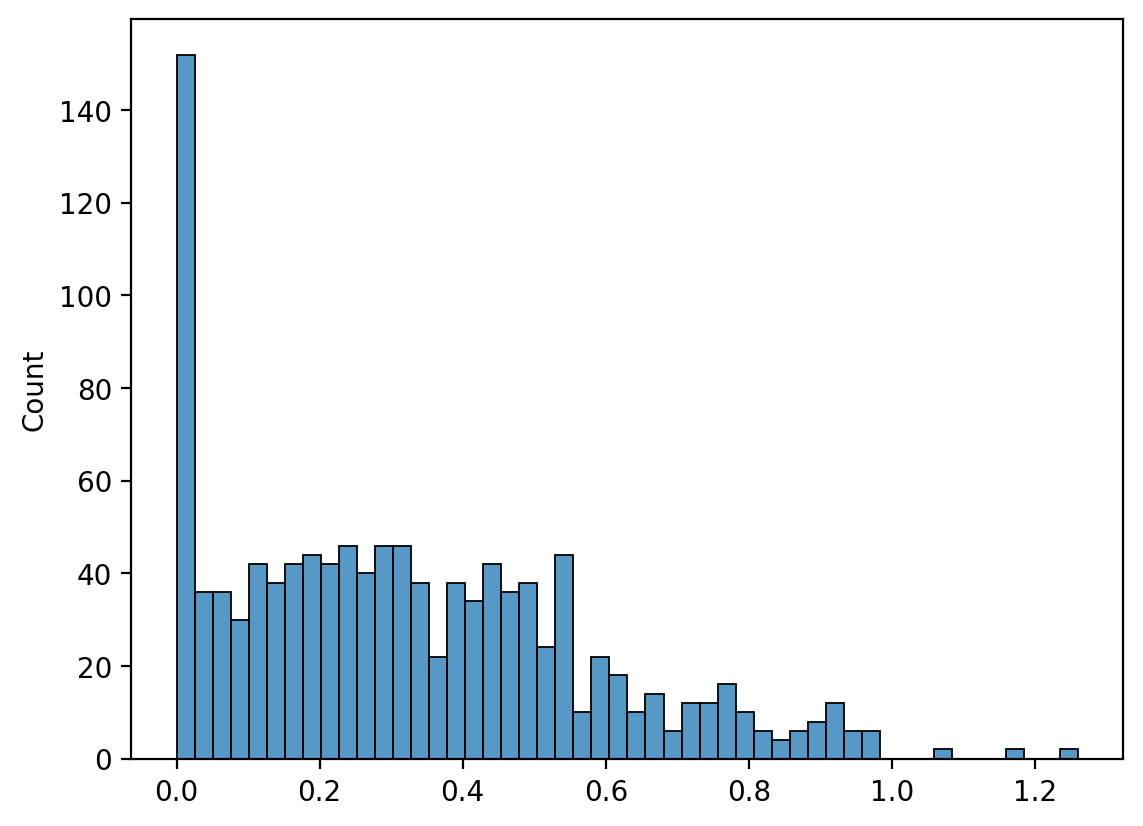

In [65]:
sns.histplot(final_metric[pass_1==1].flatten(), bins=50);

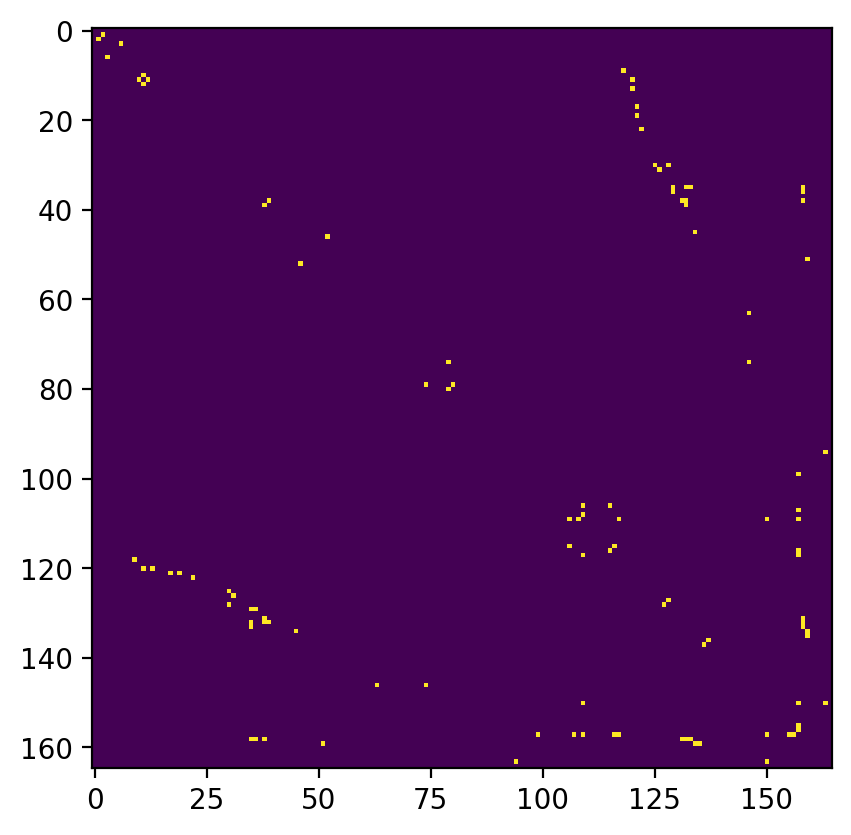

In [66]:
final_thresh = 0.7

merge_dec_final = final_metric > final_thresh
plt.imshow(merge_dec_final);

In [167]:
xcorr_sig[96,98]

0.36309312553611517

In [174]:
wass_sim[115,116]

0.7993023229001639

In [171]:
final_metric[107,157]

0.7770491291530937

In [182]:
x_olaps[51,49]

0.0

In [144]:
np.argwhere(merge_dec_final == 1)

array([[  1,   2],
       [  2,   1],
       [  3,   6],
       [  6,   3],
       [  9, 118],
       [ 10,  11],
       [ 11,  10],
       [ 11,  12],
       [ 11, 120],
       [ 12,  11],
       [ 13, 120],
       [ 17, 121],
       [ 19, 121],
       [ 22, 122],
       [ 30, 125],
       [ 30, 128],
       [ 31, 126],
       [ 35, 129],
       [ 35, 132],
       [ 35, 133],
       [ 35, 158],
       [ 36, 129],
       [ 36, 158],
       [ 38,  39],
       [ 38, 131],
       [ 38, 132],
       [ 38, 158],
       [ 39,  38],
       [ 39, 132],
       [ 45, 134],
       [ 46,  52],
       [ 51, 159],
       [ 52,  46],
       [ 63, 146],
       [ 74,  79],
       [ 74, 146],
       [ 79,  74],
       [ 79,  80],
       [ 80,  79],
       [ 94, 163],
       [ 99, 157],
       [106, 109],
       [106, 115],
       [107, 157],
       [108, 109],
       [109, 106],
       [109, 108],
       [109, 117],
       [109, 150],
       [109, 157],
       [115, 106],
       [115, 116],
       [116,

In [31]:
ref_pen[8,10]

1.0

In [76]:
(merge_dec_final).sum()/2

143.0

In [42]:
final_metric[51,136]

0.7446230938896462

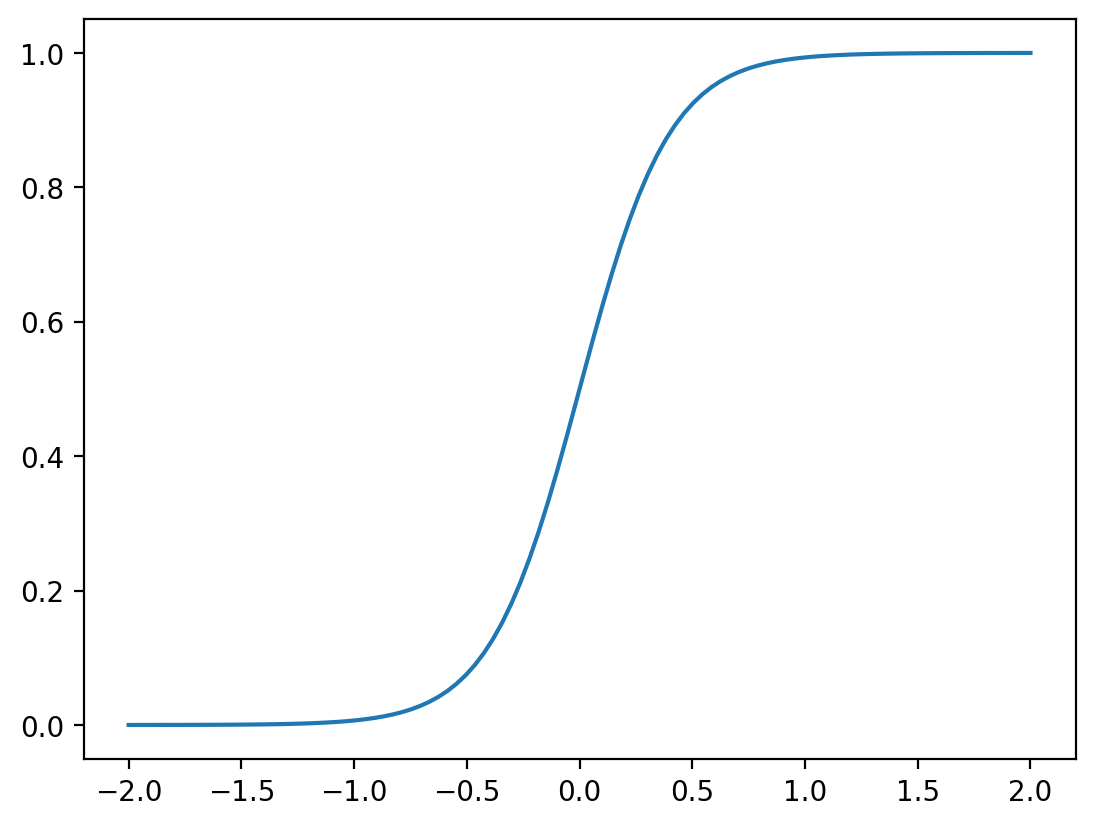

In [60]:
plt.plot(np.linspace(-2,2,100), bd.sigmoid(np.linspace(-2,2,100), -1, 1));